<a href="https://colab.research.google.com/github/ibnu666-beep/PBO_TIsem3_dvibnu/blob/main/Praktikum03_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dvibnu","key":"4c9f76654558910a62d2709709d7bbf8"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip install kaggle
  print("Kagglle API siap digunakan")
else:
  print("kaggle.json belum ditemukan. upload terlebih dahulu")

Kagglle API siap digunakan


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("dataset utkface berhasil diekstrak")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
dataset utkface berhasil diekstrak


crop_part1
UTKFace
utkface_aligned_cropped
total gambar ditemukan: 23708


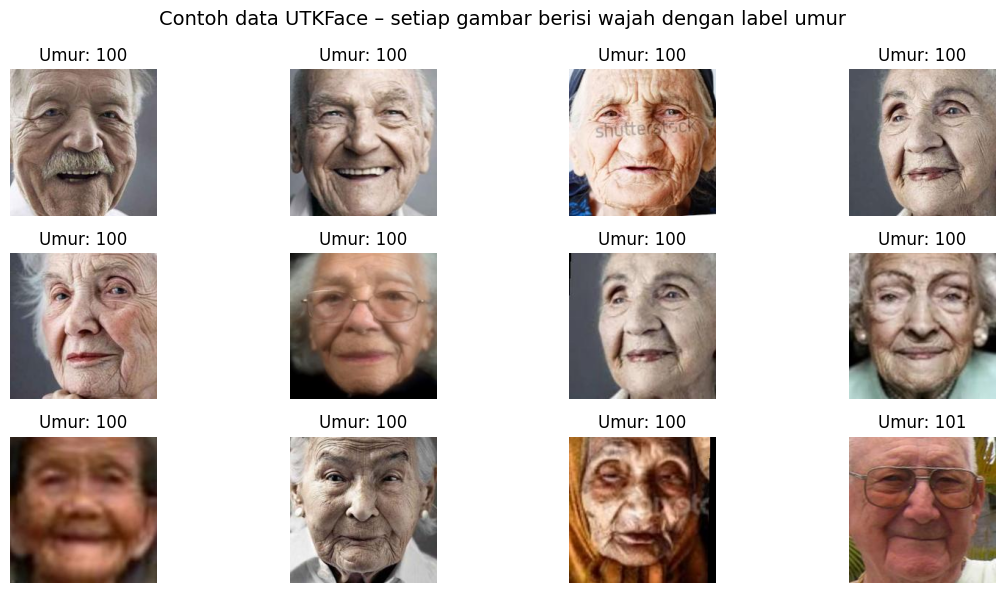

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

!ls /content/utk | head  # cek isi folder utk

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh data UTKFace – setiap gambar berisi wajah dengan label umur", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)) .map(load_img) .batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)) .map(load_img) .batch(64)

print("dataset siap dilatih.")

dataset siap dilatih.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

print("hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

IMG_SIZE = 160

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

model.summary()

hardware: GPU


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_3 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 56s 130ms/step - loss: 334.3509 - mae: 13.4623 - val_loss: 159.0470 - val_mae: 9.6193 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 156.1773 - mae: 9.2762 - val_loss: 145.6775 - val_mae: 9.0557 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 146.0422 - mae: 8.9426 - val_loss: 140.4717 - val_mae: 8.8209 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 139.1730 - mae: 8.6914 - val_loss: 139.6171 - val_mae: 8.7992 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 137.6889 - mae: 8.5490 - val_loss: 138.6605 - val_mae: 8.7678 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 135.2534 - mae: 8.4952 - val_loss: 137.4097 - val_mae: 8.6841 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 133.2450 - mae: 8.4585 - val_loss: 133.5949 - va

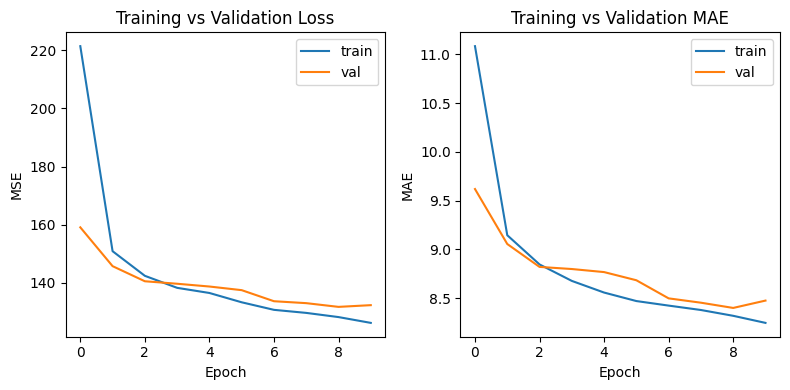

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 189.0629 - mae: 10.1481 - val_loss: 144.8422 - val_mae: 9.0537 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 78.2053 - mae: 6.5923 - val_loss: 117.2591 - val_mae: 8.0426 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - loss: 51.1280 - mae: 5.3973 - val_loss: 110.8100 - val_mae: 7.8888 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 38.0895 - mae: 4.6853 - val_loss: 127.3379 - val_mae: 8.4985 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 30.1325 - mae: 4.1853 - val_loss: 102.0312 - val_mae: 7.2816 - learning_rate: 1.0000e-04


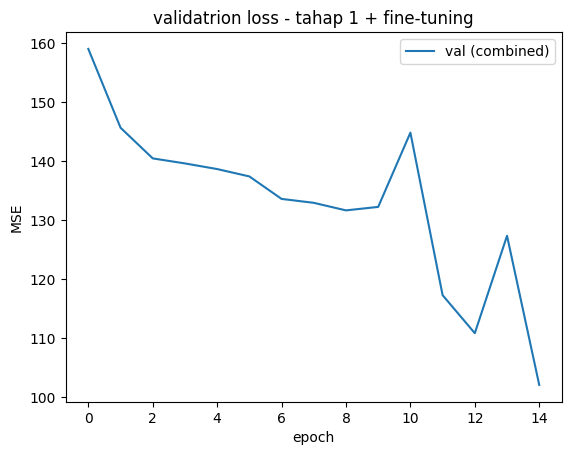

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
         label='val (combined)')
plt.title("validatrion loss - tahap 1 + fine-tuning")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

MAE = 7.28 tahun
RMSE = 10.10 tahun
R2 = 0.743


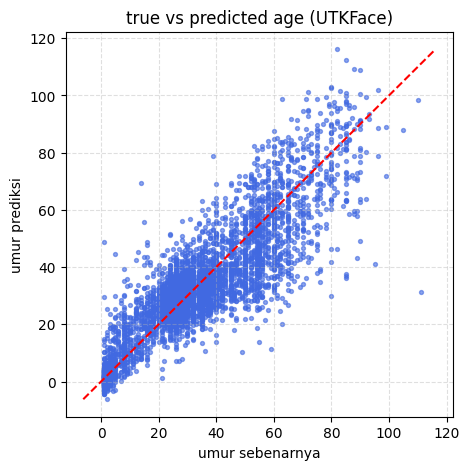

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0) .ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5,))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [
    min(y_test.min(), y_pred.min()),
    max(y_test.max(), y_pred.max())
]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("umur sebenarnya")
plt.ylabel("umur prediksi")
plt.title("true vs predicted age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

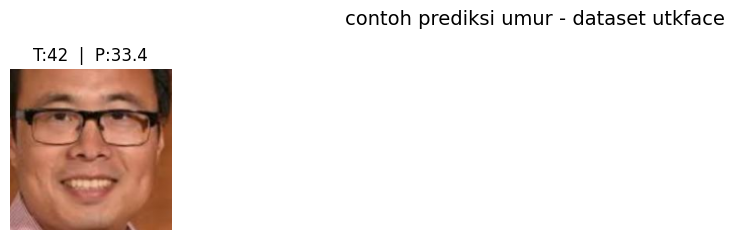

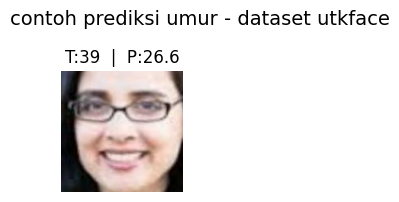

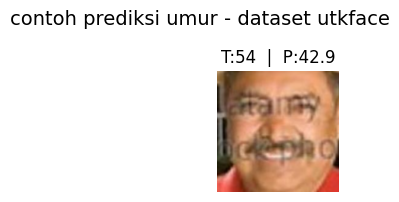

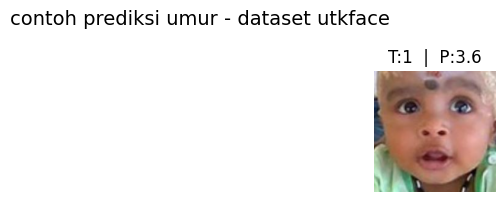

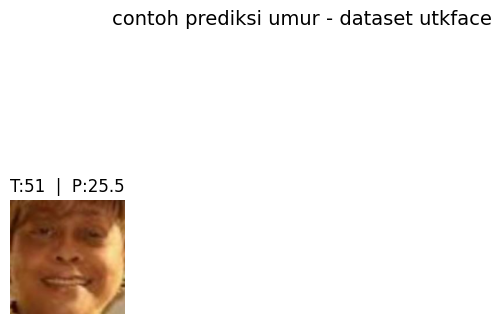

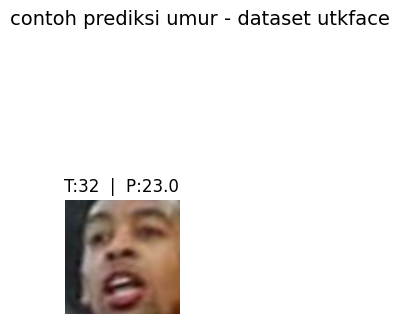

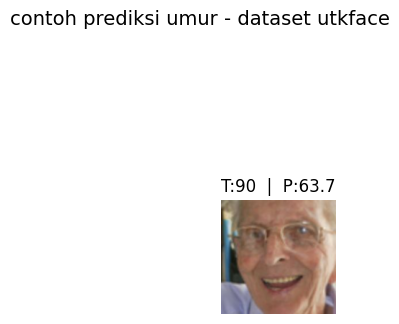

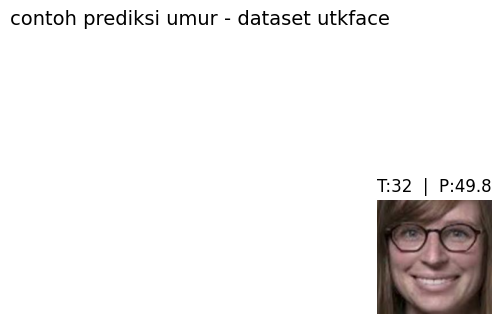

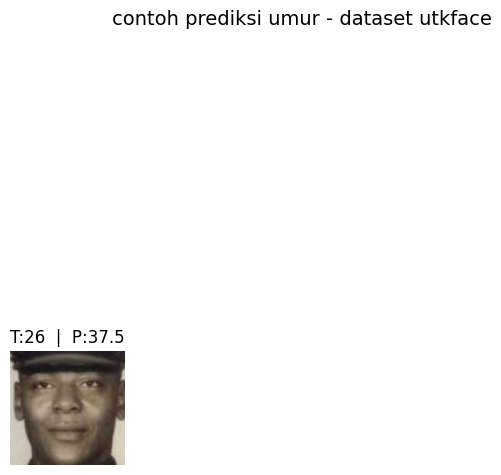

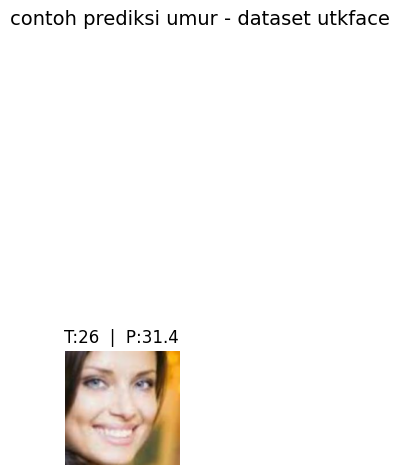

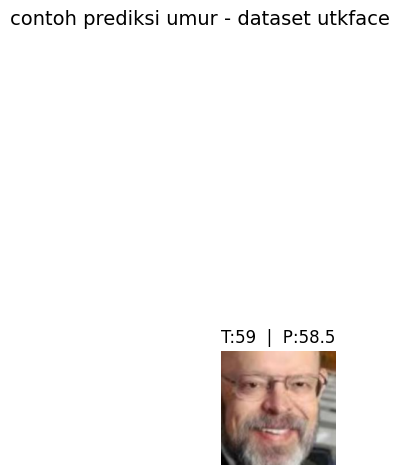

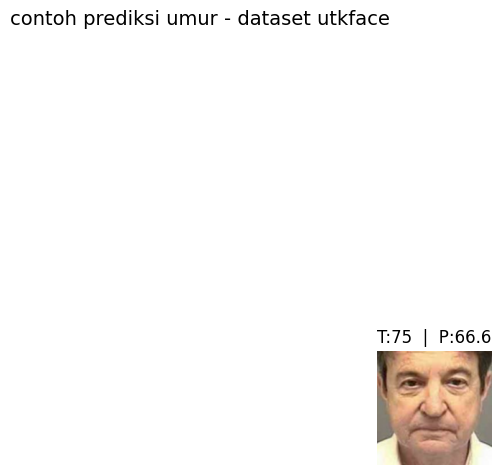

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0) .ravel() [0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age}  |  P:{pred_age:.1f}")
  plt.axis('off')
  plt.suptitle("contoh prediksi umur - dataset utkface", fontsize=14)
  plt.tight_layout()
  plt.show()

#**PRAKTIKUM D3**

In [5]:
from google.colab import files
files.upload()
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print(" kaggle API siap digunakan ")
else:
  print("kaggle.json belum ditemukan. upload terlebih dahulu")

Saving kaggle.json to kaggle.json
 kaggle API siap digunakan 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("contoh data petfinder.my pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/paw/train.csv'